# LDM

## 데이터 다운로드

In [1]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:01<00:00, 36.7MB/s]


In [2]:
# 미리 학습한 VAE 파라미터 다운
!gdown 1XXDunPNMlxZ_EO6rxAYDHgKsw3SR1XQf

Downloading...
From: https://drive.google.com/uc?id=1XXDunPNMlxZ_EO6rxAYDHgKsw3SR1XQf
To: /content/best_vae.pt
100% 31.6k/31.6k [00:00<00:00, 58.2MB/s]


In [3]:
# 미리 학습한 LDM 파라미터 다운
!gdown 1XxbYlnnx048smf7dKh-Mi346LYba2InT

Downloading...
From: https://drive.google.com/uc?id=1XxbYlnnx048smf7dKh-Mi346LYba2InT
To: /content/best_ldm.pt
100% 14.8M/14.8M [00:00<00:00, 149MB/s]


## 패키지 임포트 & 기타 설정값 세팅

In [4]:
# import the necessary packages
import os, random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [5]:
sprites = np.load('sprites_1788_16x16.npy')

In [6]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

DEVICE

'cuda'

- 이미지 사이즈와 잠재 변수 차원 세팅

In [7]:
IMAGE_SIZE = 16
CHANNELS = 3
EMBEDDING_DIM = 5

## VAE Model

- 이전 파일에서 학습한 VAE 모델 정의

In [8]:
# define a convolutional block for the encoder part of the vae
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        # 기본적으로 크기를 반으로 줄임
        super().__init__()

        # sequential block consisting of a 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels,  # number of input channels
                out_channels=out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        # pass the input through the sequential block
        return self.block(x)

# define a transposed convolutional block for the decoder part of the vae
class ConvTBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        # 기본적으로 크기를 두배로 늘림
        super().__init__()

        # sequential block consisting of a transposed 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels,  # number of input channels
                out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
                output_padding=output_padding,  # additional padding added to the output
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        return self.block(x)  # pass the input through the sequential block

# define the main vae class
class VAE(torch.nn.Module):
    """
    image          encoder        latent      decoder         final layer
    (3, 16, 16) -> (16, 8, 8) -> (5, 8, 8) -> (16, 16, 16) -> (16, 16, 16) -> (3, 16, 16)
    """
    def __init__(self, in_channels, latent_dim, hidden_dims = None):
        super().__init__()

        self.latent_dim = latent_dim  # dimensionality of the latent space
        if hidden_dims is None:
            hidden_dims = [16, ]  # default hidden dimensions
            # img size     8

        self.hidden_dims = hidden_dims[:]
        # self.feature_map_hw = int(IMAGE_SIZE / 2**len(hidden_dims))

        self.encoder = torch.nn.Sequential(
            # (3,16,16)->(16,8,8)
            ConvBlock(in_channels, hidden_dims[0]),
            # hidden_dims에 추가 레이어가 있으면
            # ConvBlock(hidden_dims[0], hidden_dims[1]),
            # ConvBlock(hidden_dims[1], hidden_dims[2]), ... 식으로 추가해주기
        )

        # layer for the mean of the latent space
        self.conv_mu = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        # layer for the variance of the latent space
        self.conv_var = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        self.decoder = torch.nn.Sequential(
            ConvTBlock(latent_dim, hidden_dims[-1]),
            # hidden_dims에 추가 레이어가 있으면
            # ConvBlock(hidden_dims[-1], hidden_dims[-2]),
            # ConvBlock(hidden_dims[-2], hidden_dims[-3]), ... 식으로 추가해주기
        )

        # final layer to reconstruct the original input
        self.final_layer = torch.nn.Sequential(
            torch.nn.Conv2d(
                hidden_dims[-1], hidden_dims[-1],
                kernel_size=3, stride=1, padding=1
            ),

            # normalize the activations of the layer
            torch.nn.BatchNorm2d(hidden_dims[-1]),

            # apply leaky relu activation
            torch.nn.LeakyReLU(),

            # final convolution to match the output channels
            torch.nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, stride=1, padding=1),
        )

    # encoding function to map the input to the latent space
    def encode(self, input):
        # pass the input through the encoder
        result = self.encoder(input) # (N,3,16,16)->(N,32,8,8)

        # compute the mean of the latent space
        mu = self.conv_mu(result) # (N,32,8,8)->(N,64,8,8)

        # compute the log variance of the latent space
        log_var = self.conv_var(result) # (N,32,8,8)->(N,64,8,8)

        return [mu, log_var]

        # decoding function to map the latent space to the reconstructed input
    def decode(self, z):
        # pass the result through the decoder
        result = self.decoder(z) # (N,64,8,8) -> (N, 32, 16, 16)

        # pass the result through the final layer
        result = self.final_layer(result) # (N, 32, 16, 16)->(N, 32, 16, 16)->(N, 3, 16, 16)
        return result

        # reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        # compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # sample random noise
        eps = torch.randn_like(std)
        # compute the sample from the latent space
        return eps * std + mu

    # forward pass of the vae
    def forward(self, input):
        # encode the input to the latent space
        mu, log_var = self.encode(input) # (N, 3, 16, 16) -> [(N, 64, 8, 8), (N, 64, 8, 8)]
        #print(mu.shape, log_var.shape)

        # sample from the latent space
        z = self.reparameterize(mu, log_var) # (N, laten dim)

        # decode the sample, and return the reconstruction
        # along with the original input, mean, and log variance
        recon_input = self.decode(z)

        return [recon_input, input, mu, log_var]

In [9]:
# create output directory
output_dir = "output"
os.makedirs("output", exist_ok=True)

model_weights_dir = os.path.join(output_dir, f"model_weights_latent2D_{EMBEDDING_DIM}")
os.makedirs(model_weights_dir, exist_ok=True)

MODEL_BEST_WEIGHTS_PATH = os.path.join(model_weights_dir, "best_vae.pt")

In [10]:
# 미리 다운 받은 best_vae_celeba_2d.pt 파일이 있으면 model_weights_dir 밑으로 이동
import shutil

if os.path.exists("./best_vae.pt"):
    shutil.move("./best_vae.pt", MODEL_BEST_WEIGHTS_PATH)

In [11]:
# Define the transformations
valid_transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

In [12]:
# VAE로 입력될 원본 이미지에 대한 데이터 셋

class MyVaeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]

        if self.transform:
            x_0 = self.transform(x_0)

        return x_0

In [13]:
seed = 100

# 전역 난수 생성기 시드 설정
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python의 random 모듈
    np.random.seed(seed_value)  # Numpy 모듈
    torch.manual_seed(seed_value)  # PyTorch를 위한 시드 설정
    torch.cuda.manual_seed_all(seed_value)  # 모든 GPU에 대한 PyTorch 시드 설정

set_seed(seed)  # 시드 값을 설정합니다.

VAE_BATCH_SIZE = 32

train_ds = MyVaeDataset(sprites, valid_transforms)
train_loader = DataLoader(train_ds, batch_size=VAE_BATCH_SIZE, shuffle=False)

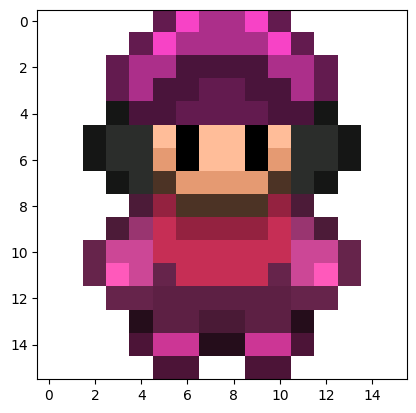

In [14]:
# 샘플 확인
plt.imshow(train_ds[0].permute(1,2,0))
plt.show()

### VAE 모델 복원

In [15]:
vae = VAE(CHANNELS, EMBEDDING_DIM)

# model load
# MODEL_BEST_WEIGHTS_PATH
# 저장된 모델 상태를 불러옵니다.
model_state = torch.load(MODEL_BEST_WEIGHTS_PATH, weights_only=True)

# 모델 상태를 현재 모델에 로드합니다.
vae.load_state_dict(model_state['vae'])
vae.eval();

torch.Size([5, 3, 16, 16])
torch.Size([5, 3, 16, 16])


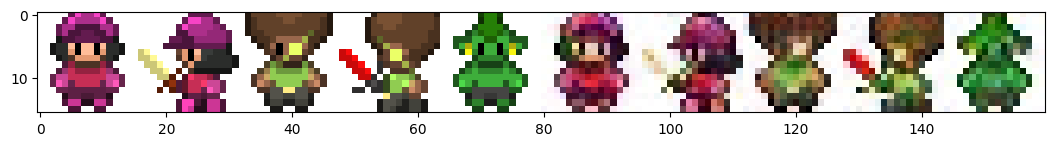

In [16]:
# VAE의 복원 실험

val_loader_iter = iter(train_loader)
x_test = next(val_loader_iter)[:5].clone()#.to(DEVICE)
print(x_test.shape)

predictions = vae(x_test)
print(predictions[0].shape)

fig = plt.figure(figsize=(13,5))
plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

In [17]:
# 모든 데이터를 latent z로 만들기
vae.to(DEVICE)

latents = []

for i, X_batched in enumerate(tqdm(train_loader)):
    X_batched = X_batched.to(DEVICE)

    mu, log_var = vae.encode(X_batched)
    z = vae.reparameterize(mu, log_var)
    z = z.detach().cpu()
    latents.append(z)

100%|██████████| 2794/2794 [00:05<00:00, 550.77it/s]


In [18]:
# 변환된 잠재 변수 개수와 잠재변수의 모양
len(latents), latents[0].shape

(2794, torch.Size([32, 5, 8, 8]))

In [19]:
# 미니 배치 32를 모두 이어 붙임
latents = torch.cat(latents, axis=0)
latents.shape

torch.Size([89400, 5, 8, 8])

- 잠재변수의 분포 확인

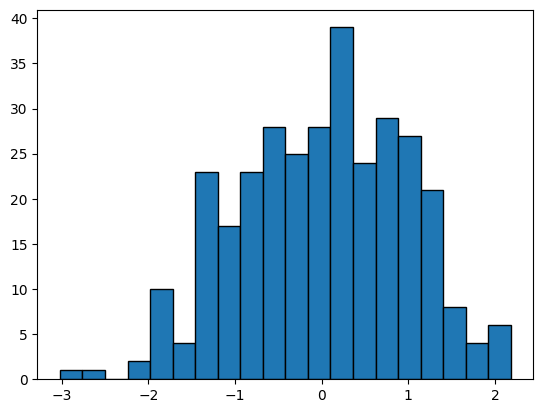

In [20]:
plt.hist(latents[0].reshape(-1), bins=20, ec='k')
plt.show()

### 잠재변수 복원 실험

torch.Size([5, 5, 8, 8])
torch.Size([5, 3, 16, 16])


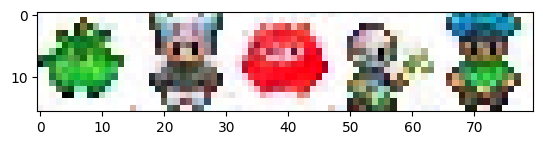

In [21]:
# 배치 차원(첫 번째 차원)을 섞기
shuffled_indices = torch.randperm(latents.size(0))
latents = latents[shuffled_indices]

x_test = latents[:5].to(DEVICE)

print(x_test.shape)

predictions = vae.decode(x_test)
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

## LDM: 잠재변수에 대한 DDPM

In [22]:
class MyDataset(Dataset):
    # beta는 DDPM 원문의 설정을 따르고
    beta_1 = 1e-4
    beta_T = 0.02
    # 시간 단계는 deeplearning.ai에서 제공하는 숏코스 How Diffusion Models Work의 설정을 따름
    T = 500

    # beta는 첨자 1부터 T까지 사용하기 위해 제일 앞에 더미 데이터 tf.constant([0.])를 추가하여 만듬
    beta = torch.cat([ torch.tensor([0]), torch.linspace(beta_1, beta_T, T)], axis=0)
    alpha = 1 - beta
    alpha_bar = torch.exp(torch.cumsum(torch.log(alpha), axis=0))

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]

        # 잠재변수를 normalize -1~1로 만들기
        if self.transform:
            x_0 = self.transform(x_0)

        # noise 추가
        t = np.random.randint(1, MyDataset.T+1)
        eps = torch.randn_like(x_0)
        x_t = torch.sqrt(MyDataset.alpha_bar[t]) * x_0 + torch.sqrt(1 - MyDataset.alpha_bar[t]) * eps

        return x_0, x_t, eps, t

In [23]:
transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize((latents.mean(),), (latents.std(),))
])

# 잠재변수에 대한 Transform은 필요없음
train_ds = MyDataset(latents, None)

BATCH_SIZE = 256 #

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
train_loader_iter = iter(train_loader)

In [24]:
samples = next(train_loader_iter)

x_0s = samples[0][:6].numpy()
x_ts = samples[1][:6].numpy()
epss = samples[2][:6].numpy()
ts =  samples[3][:6].numpy()

In [25]:
x_0s.shape, x_ts.shape, epss.shape, ts

((6, 5, 8, 8),
 (6, 5, 8, 8),
 (6, 5, 8, 8),
 array([486, 493, 397, 398, 369, 227]))

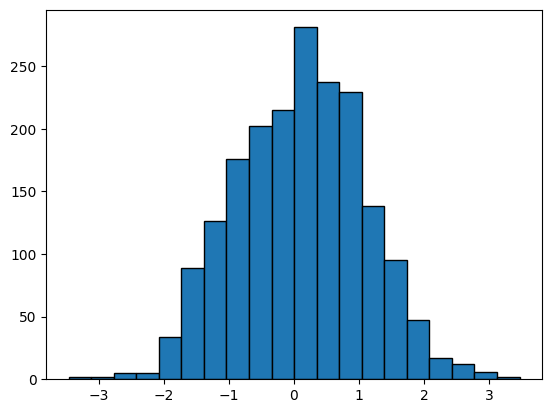

In [26]:
plt.hist(x_0s.reshape(-1), bins=20, ec='k')
plt.show()

torch.Size([6, 3, 16, 16])


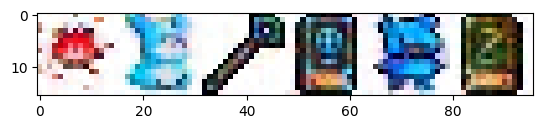

In [27]:
# 원본 잠재 변수를 디코딩
predictions = vae.decode(torch.tensor(x_0s).to(DEVICE))
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

[486 493 397 398 369 227]
torch.Size([6, 3, 16, 16])


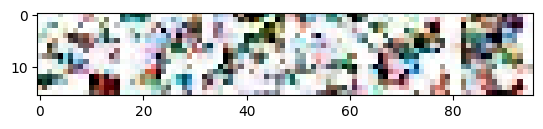

In [28]:
# 원본 잼재변수에 잡음이 추가된 x로 부터 디코딩
print(ts)
predictions = vae.decode(torch.tensor(x_ts).to(DEVICE))
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

### 모델 정의

In [29]:
class ResidualConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, is_res = True):
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = torch.nn.Sequential(
            # 3x3 kernel with stride 1 and padding 1
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),   # Batch normalization
            torch.nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = torch.nn.Sequential(
            # 3x3 kernel with stride 1 and padding 1
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),   # Batch normalization
            torch.nn.GELU(),   # GELU activation function
        )

    def forward(self, x):
        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer
                # to match dimensions before adding residual connection
                shortcut = torch.nn.Conv2d(x.shape[1], x2.shape[1],
                                     kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor, 분산을 1로 만들기 위해
            return out / 1.414 # sqrt(2)

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class UnetConv(torch.nn.Module):
    # 이미지 사이즈를 줄이지 않는 더블 컨볼루션
    def __init__(self, in_channels, out_channels):
        super().__init__()

        layers = [
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels)
        ]

        # Use the layers to create a sequential model
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class UnetDownConv(torch.nn.Module):
    # 마지막에 풀링을 둬서 이미지 사이즈를 반으로 줄이는 더블 컨볼루션
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers,
        # followed by a MaxPool2d layer for downsampling
        layers = [
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
            torch.nn.MaxPool2d(2)
        ]

        # Use the layers to create a sequential model
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class UnetUpConv(torch.nn.Module):
    # 이미지 사이즈를 두배로 늘리는 트리플 컨볼루션
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.layers = torch.nn.ModuleList([
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            torch.nn.GroupNorm(out_channels//8, out_channels), # normalize
            torch.nn.GELU(),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ])

    def forward(self, x, output_size=None):
        for i, layer in enumerate(self.layers):
            if i == 0:
                # 첫번째 컨볼루션은 이미지 사이즈를 줄이는데
                # 외부에서 넘겨준 사이즈에 맞게 조정
                x = layer(x, output_size=output_size)
            else:
                # 나머지 레이어는 그냥 진행하면 됨
                x = layer(x)

        return x


class LDM(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.emb_1 = torch.nn.Linear(in_features=1, out_features=64)
        self.emb_2 = torch.nn.Linear(in_features=64, out_features=128)

        self.down_conv1 = UnetConv(in_channels=EMBEDDING_DIM, out_channels=64)
        self.down_conv2 = UnetConv(in_channels=64, out_channels=128)
        self.down_conv3 = UnetDownConv(in_channels=128, out_channels=256)

        self.up_conv1 = UnetUpConv(in_channels=256, out_channels=128)
        self.up_conv2 = UnetConv(in_channels=128, out_channels=64)
        self.up_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            torch.nn.GroupNorm(8, 64), # normalize, 64채널을 8개 그룹으로 나눠서 노멀라이즈
            torch.nn.GELU(),
            torch.nn.Conv2d(in_channels=64, out_channels=EMBEDDING_DIM, kernel_size=3, padding=1)
        )

        self.relu = torch.nn.ReLU()

    def forward(self, x, t):
        # x: (N, C, H, W)
        # t: (N,1)
        batch_size = t.shape[0]

        # time embedding
        t = self.relu( self.emb_1(t) ) # (N, 64)
        t = self.relu( self.emb_2(t) ) # (N, 128)
        t = t.reshape(batch_size, -1, 1, 1) # (N, 128, 1, 1)

        # image down conv
        x_64 = self.down_conv1(x)  # (N, 5, 8, 8)->(N, 64, 8, 8)
        size_64 = x_64.shape
        x_128 = self.down_conv2(x_64) # (N, 64, 8, 8)->(N, 128, 8, 8)

        # add time embedding
        x = x_128 + t # (N, 128, 8, 8) + (N, 128, 1, 1) -> (N, 128, 4, 4)
        x =  self.down_conv3(x) # (N, 128, 8, 8) -> (N, 256, 4, 4)

        # image up conv
        x = self.up_conv1(x, output_size=size_64) # (N, 256, 4, 4) -> (N, 128, 8, 8)
        x = self.up_conv2(x) # (N, 128, 8, 8) -> (N, 64, 8, 8)

        # skip connection
        x = torch.concat([x, x_64], axis=1) # (N, 64, 8, 8)+(N, 64, 8, 8) -> (N, 128, 8, 8)
        out = self.up_conv3(x) # (N, 128, 8, 8) -> (N, 64, 8, 8) -> (N, 5, 8, 8)

        return out

In [30]:
model = LDM()
model = model.to(DEVICE)

### 포워드 테스트

In [31]:
output = model(samples[0].to(DEVICE), samples[3].reshape(-1,1).float().to(DEVICE))

print(output.shape)

torch.Size([256, 5, 8, 8])


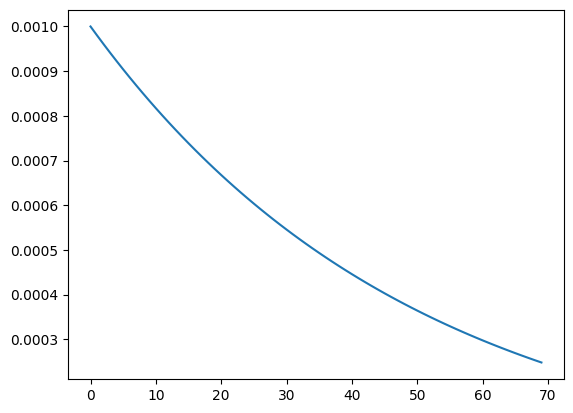

In [32]:
epochs = 70
scheduler_gamma = 0.98
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

#####################################################################################
# 러닝 레이트 스캐쥴 시뮬레이션
# https://panggu15.github.io/etc/pytorch-learning-rate-Scheduler/
lrs = []
for i in range(epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(epochs),lrs)
plt.show()
####################################################################################


In [33]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

# 초기 러닝레이트
optimizer.param_groups[0]['lr']

0.001

### 학습

In [35]:
losses = []
best_loss = float("inf")

for e in range(epochs):
    epoch_loss = 0.0
    epoch_mae = 0.0

    for i, data in enumerate(tqdm(train_loader)):
        x_0, x_t, eps, t = data
        x_t = x_t.to(DEVICE)
        eps = eps.to(DEVICE)
        t = t.to(DEVICE)

        optimizer.zero_grad()
        eps_theta = model(x_t, t.reshape(-1,1).float())
        loss = loss_func(eps_theta, eps)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()
            epoch_mae += torch.nn.functional.l1_loss(eps_theta, eps)

    epoch_loss /= len(train_loader)
    epoch_mae /= len(train_loader)

    print(f"Epoch: {e+1:2d}: loss:{epoch_loss:.4f}, mae:{epoch_mae:.4f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({"vae": model.state_dict()}, f"best_ldm.pt")

    losses.append(epoch_loss)

    # 스케쥴러 안돌리는게 낫고, 50에폭까지 0.001, 51에폭부터 0.0001로 하는 걸로 실험해볼 필요는 있음
    # scheduler.step()


100%|██████████| 350/350 [00:08<00:00, 41.73it/s]


Epoch:  1: loss:0.4821, mae:0.5230


100%|██████████| 350/350 [00:07<00:00, 45.21it/s]


Epoch:  2: loss:0.4017, mae:0.4633


100%|██████████| 350/350 [00:07<00:00, 46.64it/s]


Epoch:  3: loss:0.3854, mae:0.4484


100%|██████████| 350/350 [00:07<00:00, 46.97it/s]


Epoch:  4: loss:0.3743, mae:0.4385


100%|██████████| 350/350 [00:07<00:00, 48.35it/s]


Epoch:  5: loss:0.3654, mae:0.4312


100%|██████████| 350/350 [00:07<00:00, 46.69it/s]


Epoch:  6: loss:0.3521, mae:0.4203


100%|██████████| 350/350 [00:07<00:00, 46.08it/s]


Epoch:  7: loss:0.3416, mae:0.4119


100%|██████████| 350/350 [00:07<00:00, 45.22it/s]


Epoch:  8: loss:0.3332, mae:0.4050


100%|██████████| 350/350 [00:07<00:00, 45.64it/s]


Epoch:  9: loss:0.3217, mae:0.3956


100%|██████████| 350/350 [00:07<00:00, 45.77it/s]


Epoch: 10: loss:0.3183, mae:0.3922


100%|██████████| 350/350 [00:08<00:00, 43.12it/s]


Epoch: 11: loss:0.3134, mae:0.3883


100%|██████████| 350/350 [00:07<00:00, 46.42it/s]


Epoch: 12: loss:0.3070, mae:0.3831


100%|██████████| 350/350 [00:07<00:00, 44.86it/s]


Epoch: 13: loss:0.3038, mae:0.3805


100%|██████████| 350/350 [00:07<00:00, 45.64it/s]


Epoch: 14: loss:0.3010, mae:0.3776


100%|██████████| 350/350 [00:07<00:00, 49.90it/s]


Epoch: 15: loss:0.2973, mae:0.3750


100%|██████████| 350/350 [00:07<00:00, 46.26it/s]


Epoch: 16: loss:0.2936, mae:0.3719


100%|██████████| 350/350 [00:07<00:00, 45.15it/s]


Epoch: 17: loss:0.2915, mae:0.3702


100%|██████████| 350/350 [00:07<00:00, 47.12it/s]


Epoch: 18: loss:0.2882, mae:0.3672


100%|██████████| 350/350 [00:07<00:00, 48.32it/s]


Epoch: 19: loss:0.2845, mae:0.3641


100%|██████████| 350/350 [00:07<00:00, 45.75it/s]


Epoch: 20: loss:0.2835, mae:0.3633


100%|██████████| 350/350 [00:06<00:00, 50.13it/s]


Epoch: 21: loss:0.2813, mae:0.3617


100%|██████████| 350/350 [00:07<00:00, 48.76it/s]


Epoch: 22: loss:0.2791, mae:0.3601


100%|██████████| 350/350 [00:07<00:00, 48.99it/s]


Epoch: 23: loss:0.2777, mae:0.3586


100%|██████████| 350/350 [00:07<00:00, 44.76it/s]


Epoch: 24: loss:0.2759, mae:0.3570


100%|██████████| 350/350 [00:07<00:00, 46.49it/s]


Epoch: 25: loss:0.2745, mae:0.3562


100%|██████████| 350/350 [00:07<00:00, 48.81it/s]


Epoch: 26: loss:0.2735, mae:0.3551


100%|██████████| 350/350 [00:07<00:00, 48.57it/s]


Epoch: 27: loss:0.2713, mae:0.3532


100%|██████████| 350/350 [00:07<00:00, 47.12it/s]


Epoch: 28: loss:0.2715, mae:0.3531


100%|██████████| 350/350 [00:07<00:00, 48.64it/s]


Epoch: 29: loss:0.2687, mae:0.3511


100%|██████████| 350/350 [00:07<00:00, 47.74it/s]


Epoch: 30: loss:0.2660, mae:0.3490


100%|██████████| 350/350 [00:07<00:00, 46.71it/s]


Epoch: 31: loss:0.2670, mae:0.3495


100%|██████████| 350/350 [00:07<00:00, 45.00it/s]


Epoch: 32: loss:0.2650, mae:0.3478


100%|██████████| 350/350 [00:07<00:00, 47.23it/s]


Epoch: 33: loss:0.2678, mae:0.3500


100%|██████████| 350/350 [00:07<00:00, 47.60it/s]


Epoch: 34: loss:0.2633, mae:0.3463


100%|██████████| 350/350 [00:07<00:00, 46.36it/s]


Epoch: 35: loss:0.2620, mae:0.3452


100%|██████████| 350/350 [00:07<00:00, 45.61it/s]


Epoch: 36: loss:0.2606, mae:0.3443


100%|██████████| 350/350 [00:07<00:00, 48.82it/s]


Epoch: 37: loss:0.2624, mae:0.3451


100%|██████████| 350/350 [00:07<00:00, 47.34it/s]


Epoch: 38: loss:0.2586, mae:0.3422


100%|██████████| 350/350 [00:07<00:00, 45.26it/s]


Epoch: 39: loss:0.2591, mae:0.3429


100%|██████████| 350/350 [00:07<00:00, 44.84it/s]


Epoch: 40: loss:0.2582, mae:0.3415


100%|██████████| 350/350 [00:07<00:00, 49.02it/s]


Epoch: 41: loss:0.2598, mae:0.3427


100%|██████████| 350/350 [00:07<00:00, 49.32it/s]


Epoch: 42: loss:0.2584, mae:0.3418


100%|██████████| 350/350 [00:07<00:00, 45.55it/s]


Epoch: 43: loss:0.2558, mae:0.3397


100%|██████████| 350/350 [00:07<00:00, 45.20it/s]


Epoch: 44: loss:0.2574, mae:0.3405


100%|██████████| 350/350 [00:07<00:00, 48.71it/s]


Epoch: 45: loss:0.2540, mae:0.3383


100%|██████████| 350/350 [00:07<00:00, 48.43it/s]


Epoch: 46: loss:0.2561, mae:0.3394


100%|██████████| 350/350 [00:07<00:00, 49.83it/s]


Epoch: 47: loss:0.2562, mae:0.3394


100%|██████████| 350/350 [00:07<00:00, 46.55it/s]


Epoch: 48: loss:0.2537, mae:0.3376


100%|██████████| 350/350 [00:07<00:00, 45.29it/s]


Epoch: 49: loss:0.2545, mae:0.3380


100%|██████████| 350/350 [00:07<00:00, 47.78it/s]


Epoch: 50: loss:0.2534, mae:0.3371


100%|██████████| 350/350 [00:07<00:00, 49.48it/s]


Epoch: 51: loss:0.2519, mae:0.3358


100%|██████████| 350/350 [00:07<00:00, 48.78it/s]


Epoch: 52: loss:0.2552, mae:0.3382


100%|██████████| 350/350 [00:07<00:00, 49.76it/s]


Epoch: 53: loss:0.2520, mae:0.3358


100%|██████████| 350/350 [00:07<00:00, 45.96it/s]


Epoch: 54: loss:0.2523, mae:0.3359


100%|██████████| 350/350 [00:07<00:00, 49.54it/s]


Epoch: 55: loss:0.2496, mae:0.3339


100%|██████████| 350/350 [00:07<00:00, 47.46it/s]


Epoch: 56: loss:0.2496, mae:0.3339


100%|██████████| 350/350 [00:07<00:00, 47.00it/s]


Epoch: 57: loss:0.2515, mae:0.3354


100%|██████████| 350/350 [00:07<00:00, 44.25it/s]


Epoch: 58: loss:0.2505, mae:0.3340


100%|██████████| 350/350 [00:07<00:00, 47.55it/s]


Epoch: 59: loss:0.2511, mae:0.3346


100%|██████████| 350/350 [00:07<00:00, 44.66it/s]


Epoch: 60: loss:0.2502, mae:0.3338


100%|██████████| 350/350 [00:07<00:00, 48.43it/s]


Epoch: 61: loss:0.2501, mae:0.3335


100%|██████████| 350/350 [00:07<00:00, 46.54it/s]


Epoch: 62: loss:0.2495, mae:0.3330


100%|██████████| 350/350 [00:08<00:00, 42.47it/s]


Epoch: 63: loss:0.2502, mae:0.3336


100%|██████████| 350/350 [00:07<00:00, 49.10it/s]


Epoch: 64: loss:0.2493, mae:0.3331


100%|██████████| 350/350 [00:07<00:00, 46.53it/s]


Epoch: 65: loss:0.2492, mae:0.3327


100%|██████████| 350/350 [00:07<00:00, 49.29it/s]


Epoch: 66: loss:0.2474, mae:0.3312


100%|██████████| 350/350 [00:07<00:00, 47.20it/s]


Epoch: 67: loss:0.2478, mae:0.3315


100%|██████████| 350/350 [00:07<00:00, 48.31it/s]


Epoch: 68: loss:0.2471, mae:0.3306


100%|██████████| 350/350 [00:07<00:00, 47.40it/s]


Epoch: 69: loss:0.2483, mae:0.3319


100%|██████████| 350/350 [00:07<00:00, 48.24it/s]

Epoch: 70: loss:0.2486, mae:0.3319


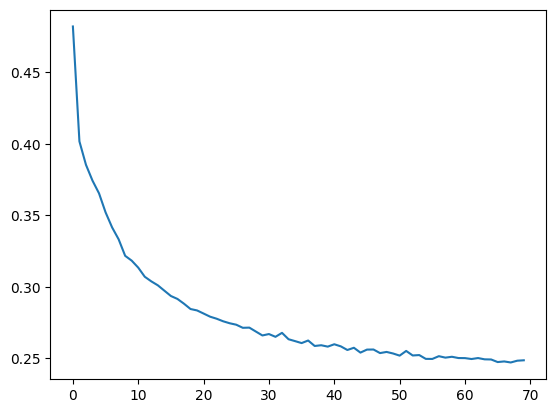

In [36]:
plt.plot(losses)
plt.show()

In [34]:
# model load
# MODEL_BEST_WEIGHTS_PATH
# 저장된 모델 상태를 불러옵니다.
model_state = torch.load("best_ldm.pt", weights_only=True)

# 모델 상태를 현재 모델에 로드합니다.
model.load_state_dict(model_state['vae'])
model.eval();


In [35]:
alpha = MyDataset.alpha.to(DEVICE)
alpha_bar = MyDataset.alpha_bar.to(DEVICE)
beta = MyDataset.beta.to(DEVICE)
T = MyDataset.T

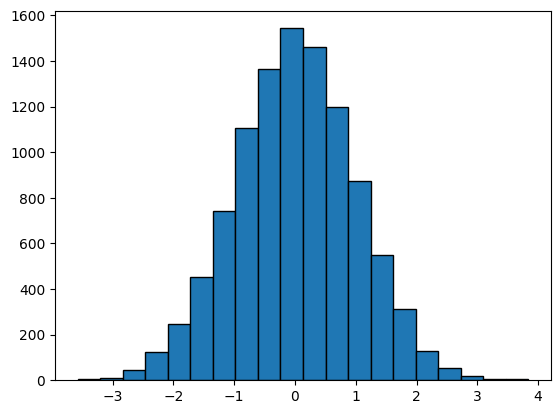

In [36]:
# 샘플링 단계동안 생성된 이미지를 일정 간격마다 저장할 리스트를 준비
N = 32 # 모델에 입력할 샘플 개수
C = 5
H = 8
W = 8

# torch.manual_seed(311) # 4, 7

# 최초 노이즈 샘플링
latent_noised = torch.randn(size=(N, C, H, W)).to(DEVICE)

plt.hist(latent_noised.detach().cpu().reshape(-1), bins=20, ec='k')

x = latent_noised.clone()

100%|██████████| 500/500 [00:04<00:00, 121.73it/s]


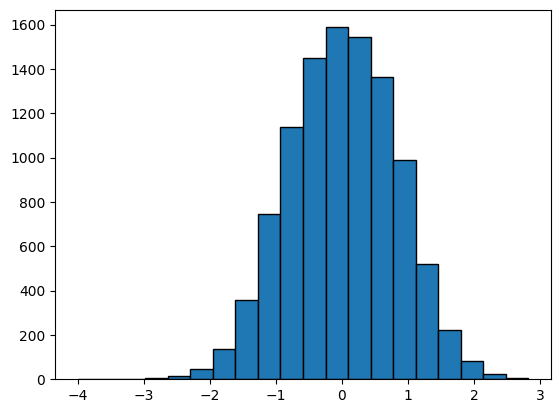

In [37]:
intermediate = []
save_rate = 20

with torch.no_grad():  # 그라디언트 추적 비활성화
    for t in tqdm(range(T, 0, -1)):
        if t > 1:
            z = torch.randn(size=(N,C,H,W)).to(DEVICE)
        else:
            z = torch.zeros((N,C,H,W)).to(DEVICE)

        t_torch = torch.tensor([[t]]*N, dtype=torch.float32).to(DEVICE)

        eps_theta = model(x, t_torch)

        x = (1 / torch.sqrt(alpha[t])) * \
            (x - ((1-alpha[t])/torch.sqrt(1-alpha_bar[t]))*eps_theta) + torch.sqrt(beta[t])*z

        if t % save_rate == 0 or t == T or t < 8:
            intermediate.append(x)

        # Clean up memory
        del z, t_torch, eps_theta
        torch.cuda.empty_cache()

plt.hist(x.detach().cpu().reshape(-1), bins=20, ec='k')
plt.show()

torch.Size([32, 3, 16, 16])


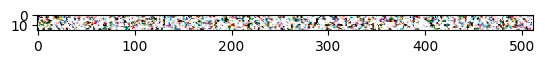

In [38]:
# 최초 노이즈를 바로 디코딩
predictions = vae.decode(latent_noised)
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

torch.Size([32, 3, 16, 16])


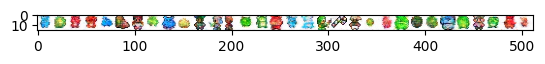

In [40]:
predictions = vae.decode(x)
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

In [39]:
# 노이즈 제거 과정에서 담아둔 단계별 잠재 변수를 단계별로 디코딩하고
# 아래쪽 애니메이션 만들 때 사용
intermediate_img = []

for frame in intermediate:
    # 디코딩된 이미지의 모임 (32, 3, 16, 16)
    predictions = vae.decode(frame)
    intermediate_img.append(predictions.detach().cpu().numpy())

# [(32, 3, 16, 16), ..., (32, 3, 16, 16)] => (32, 32, 3, 16, 16)
intermediate_img = np.stack(intermediate_img)

# (frame, sample, C, H, W)
# 32단계에서 32개의 이미지를 저장하고 있음
intermediate_img.shape


(32, 32, 3, 16, 16)

In [41]:
from matplotlib.animation import FuncAnimation, PillowWriter

In [42]:
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))

    return (x - xmin) / (xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)

    for t in range(n_t): # 32 프레임에
        for s in range(n_s): # 32 샘플에 대해서
            # 모든 프레임에 모든 이미지를 [0,1]로 노멀라이즈
            nstore[t,s] = unorm(store[t,s])

    return nstore

def plot_sample(x_gen_store, n_sample, nrows, save_dir, fn,  w, save=False):
    ncols = n_sample//nrows

    # change to Numpy image format (h,w,channels) vs (channels,h,w)
    sx_gen_store = np.moveaxis(x_gen_store, 2, 4)

    # unity norm to put in range [0,1] for np.imshow
    # nsx_gen_store: (32, 32, 16, 16, 3)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))

    def animate_diff(i, store):
        plots = []

        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append( axs[row, col].imshow( store[ i, (row*ncols)+col ] ) )

        return plots

    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],
                        interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()

    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")

    return ani

In [43]:
ani_ddpm = plot_sample(intermediate_img, 32, 4, './', "ani", 5, True)

saved gif at ./ani_w5.gif


In [44]:
from IPython.display import HTML

HTML(ani_ddpm.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.